# Importing required libraries

In [ ]:
import os
import yaml
import glob
import time
import shutil
import pathlib
import zipfile
import itertools
import kagglehub
from PIL import Image
import xml.etree.ElementTree as ET

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, Reshape

import warnings
warnings.filterwarnings("ignore")

# Constants

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 112, 112
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)  # Target frame size (resize) (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 15
BATCH_SIZE = 32
MIN_AREA  = 500
COLOR_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)
CLASS_DICT = {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}

# Importing the dataset from kaggle

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.', andrewmvd_lung_and_colon_cancer_histopathological_images_path)

Data source import complete. /kaggle/input/lung-and-colon-cancer-histopathological-images


## Loading the dataset

In [ ]:
data_dir = andrewmvd_lung_and_colon_cancer_histopathological_images_path + '/lung_colon_image_set'
filepaths = []
labels = []

folders = os.listdir(data_dir)
print(folders)
for fold in folders:
    fold_path = os.path.join(data_dir, fold)
    sub_folder = os.listdir(fold_path)
    print(sub_folder)

    if not os.path.isdir(fold_path):
        continue

    for f in sub_folder:
        f_path = os.path.join(fold_path, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'img_paths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

['colon_image_sets', 'lung_image_sets']
['colon_aca', 'colon_n']
['lung_aca', 'lung_scc', 'lung_n']


In [ ]:
df

img_paths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

## Data preprocessing

Check if data is imbalanced

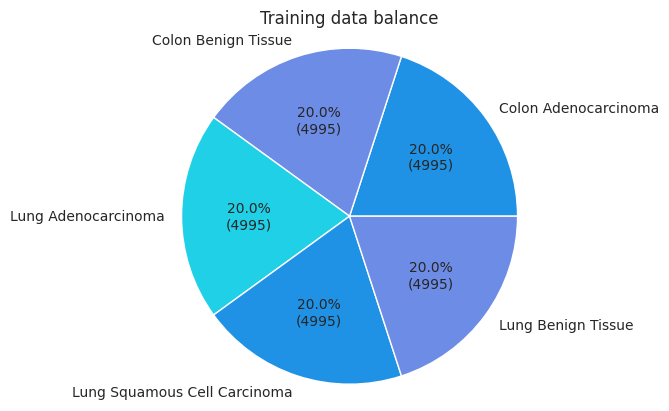

In [ ]:
data_balance = df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

## Extract some images for local testing

In [ ]:
local_test_dir = 'local_test_images'
os.makedirs(local_test_dir, exist_ok=True)

unique_labels = set(labels) # to get unique results
for label in unique_labels:
    label_dir = os.path.join(local_test_dir, label.replace(' ', '_'))
    os.makedirs(label_dir, exist_ok=True)

Fseries = pd.Series(filepaths, name='img_paths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

local_test_df = df.groupby('labels').sample(n=5, random_state=123)

for idx, row in local_test_df.iterrows():
    src = row['img_paths']
    label = row['labels']
    dest_folder = os.path.join(local_test_dir, label.replace(' ', '_'))
    shutil.copy(src, dest_folder)  # copy instead of move to avoid losing data

# Remove local test images from the main dataframe
df = df[~df['img_paths'].isin(local_test_df['img_paths'])]

print(f"Local test set created with {len(local_test_df)} images.")

Local test set created with 25 images.


In [ ]:
!zip -r /content/local_test_images.zip /content/local_test_images

  adding: content/local_test_images/ (stored 0%)
  adding: content/local_test_images/Colon_Adenocarcinoma/ (stored 0%)
  adding: content/local_test_images/Colon_Adenocarcinoma/colonca3076.jpeg (deflated 0%)
  adding: content/local_test_images/Colon_Adenocarcinoma/colonca967.jpeg (deflated 0%)
  adding: content/local_test_images/Colon_Adenocarcinoma/colonca3853.jpeg (deflated 0%)
  adding: content/local_test_images/Colon_Adenocarcinoma/colonca1557.jpeg (deflated 0%)
  adding: content/local_test_images/Colon_Adenocarcinoma/colonca3891.jpeg (deflated 0%)
  adding: content/local_test_images/Lung_Benign_Tissue/ (stored 0%)
  adding: content/local_test_images/Lung_Benign_Tissue/lungn698.jpeg (deflated 1%)
  adding: content/local_test_images/Lung_Benign_Tissue/lungn4881.jpeg (deflated 0%)
  adding: content/local_test_images/Lung_Benign_Tissue/lungn1499.jpeg (deflated 1%)
  adding: content/local_test_images/Lung_Benign_Tissue/lungn3111.jpeg (deflated 1%)
  adding: content/local_test_images/Lun

In [ ]:
def segment_image(img_path):
    """
    Applies basic Canny edge segmentation to an image.

    Args:
        img_path (str): Path to the input image.

    Returns:
        np.array: Segmented (edge-detected) image.
    """
    img = cv2.imread(img_path)  # Load image
    img = cv2.resize(img, (224, 224))  # Resize to match model input
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    edges = cv2.Canny(img, threshold1=100, threshold2=200)  # Apply Canny edge detection
    return edges

In [ ]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= df['labels'])

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= dummy_df['labels'])

## Segmentation

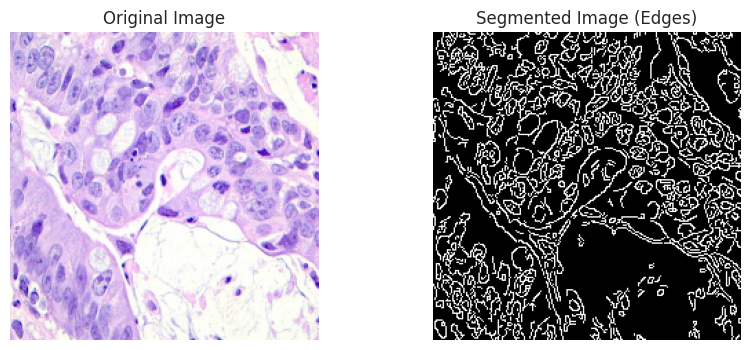

In [ ]:
sample_img_path = train_df.iloc[0]['img_paths']

# Segment the image
segmented_img = segment_image(sample_img_path)

# Plot original and segmented
original_img = cv2.imread(sample_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (224, 224))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Segmented Image (Edges)')
plt.imshow(segmented_img, cmap='gray')
plt.axis('off')

plt.show()

Create image data generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='img_paths', y_col='labels', target_size=IMG_SIZE,
                                              class_mode='categorical', color_mode= 'rgb', batch_size=BATCH_SIZE, shuffle=True)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, x_col='img_paths', y_col='labels', target_size=IMG_SIZE,
                                              class_mode='categorical', color_mode= 'rgb', batch_size=BATCH_SIZE, shuffle=True)

test_gen = valid_datagen.flow_from_dataframe(test_df, x_col= 'img_paths', y_col= 'labels', target_size= IMG_SIZE,
                                            class_mode= 'categorical',color_mode= 'rgb', shuffle= False, batch_size= BATCH_SIZE)

Found 19980 validated image filenames belonging to 5 classes.
Found 2497 validated image filenames belonging to 5 classes.
Found 2498 validated image filenames belonging to 5 classes.


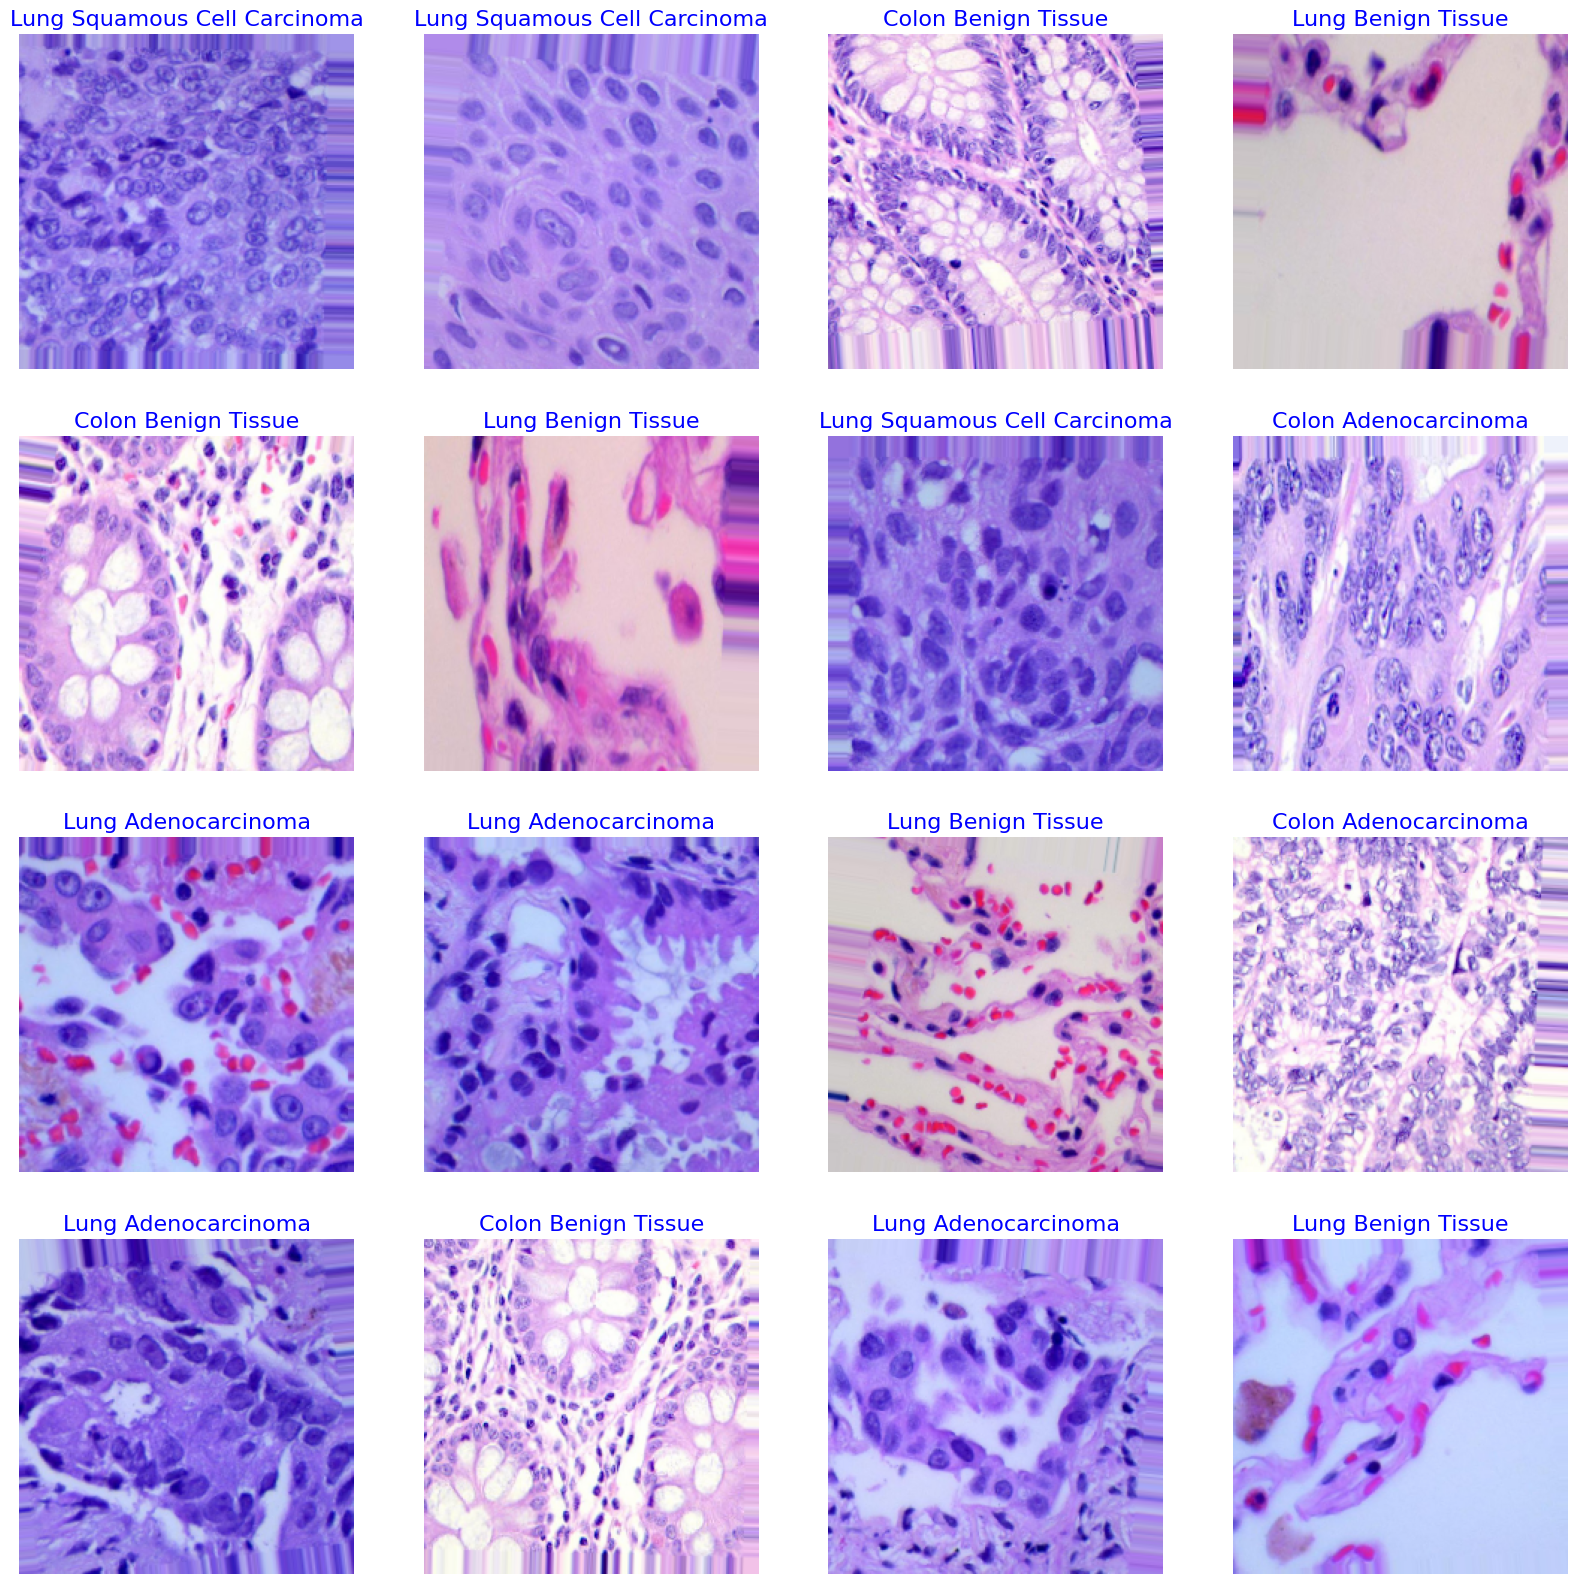

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

In [ ]:
NUM_CLASSES = len(list(train_gen.class_indices.keys()))
print("Number of classes: ", NUM_CLASSES)

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= IMG_SHAPE),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    # Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(NUM_CLASSES, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Number of classes:  5


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,542,661 (200.43 MB)

 Trainable params: 52,542,661 (200.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x=train_gen,
    epochs=15,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 350s 553ms/step - accuracy: 0.6622 - loss: 0.8150 - val_accuracy: 0.8742 - val_loss: 0.3016
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 348s 556ms/step - accuracy: 0.8633 - loss: 0.3369 - val_accuracy: 0.8058 - val_loss: 0.5287
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 356s 570ms/step - accuracy: 0.9139 - loss: 0.2201 - val_accuracy: 0.9091 - val_loss: 0.2201
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 342s 547ms/step - accuracy: 0.9374 - loss: 0.1697 - val_accuracy: 0.9592 - val_loss: 0.1207
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 350s 560ms/step - accuracy: 0.9472 - loss: 0.1440 - val_accuracy: 0.9503 - val_loss: 0.1327
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 354s 566ms/step - accuracy: 0.9566 - loss: 0.1178 - val_accuracy: 0.9648 - val_loss: 0.1075
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 357s 570ms/step - accuracy: 0.9612 - loss: 0.1073 - val_accuracy: 0.9495 - val_loss: 0.1374
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 347s 556ms/step - accuracy: 0.9704 -

In [ ]:
train_loss, train_accuracy = model.evaluate(train_gen, verbose=1)
valid_loss, valid_accuracy = model.evaluate(valid_gen, verbose=1)
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

print(f"Test Loss: {train_loss:.4f}")
print(f"Test Accuracy: {train_accuracy:.4f}")
print('-' * 20)
print(f"Test Loss: {valid_loss:.4f}")
print(f"Test Accuracy: {valid_accuracy:.4f}")
print('-' * 20)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 294s 470ms/step - accuracy: 0.9951 - loss: 0.0149
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9956 - loss: 0.0168
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.9979 - loss: 0.0132
Test Loss: 0.0146
Test Accuracy: 0.9956
--------------------
Test Loss: 0.0176
Test Accuracy: 0.9960
--------------------
Test Loss: 0.0124
Test Accuracy: 0.9980


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step


# Evaluation Metrics

### Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

y_true = test_gen.classes

class_labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step
                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       500
         Colon Benign Tissue       1.00      1.00      1.00       499
         Lung Adenocarcinoma       0.99      1.00      1.00       500
          Lung Benign Tissue       1.00      1.00      1.00       499
Lung Squamous Cell Carcinoma       1.00      0.99      1.00       500

                    accuracy                           1.00      2498
                   macro avg       1.00      1.00      1.00      2498
                weighted avg       1.00      1.00      1.00      2498



### Confusion matrix

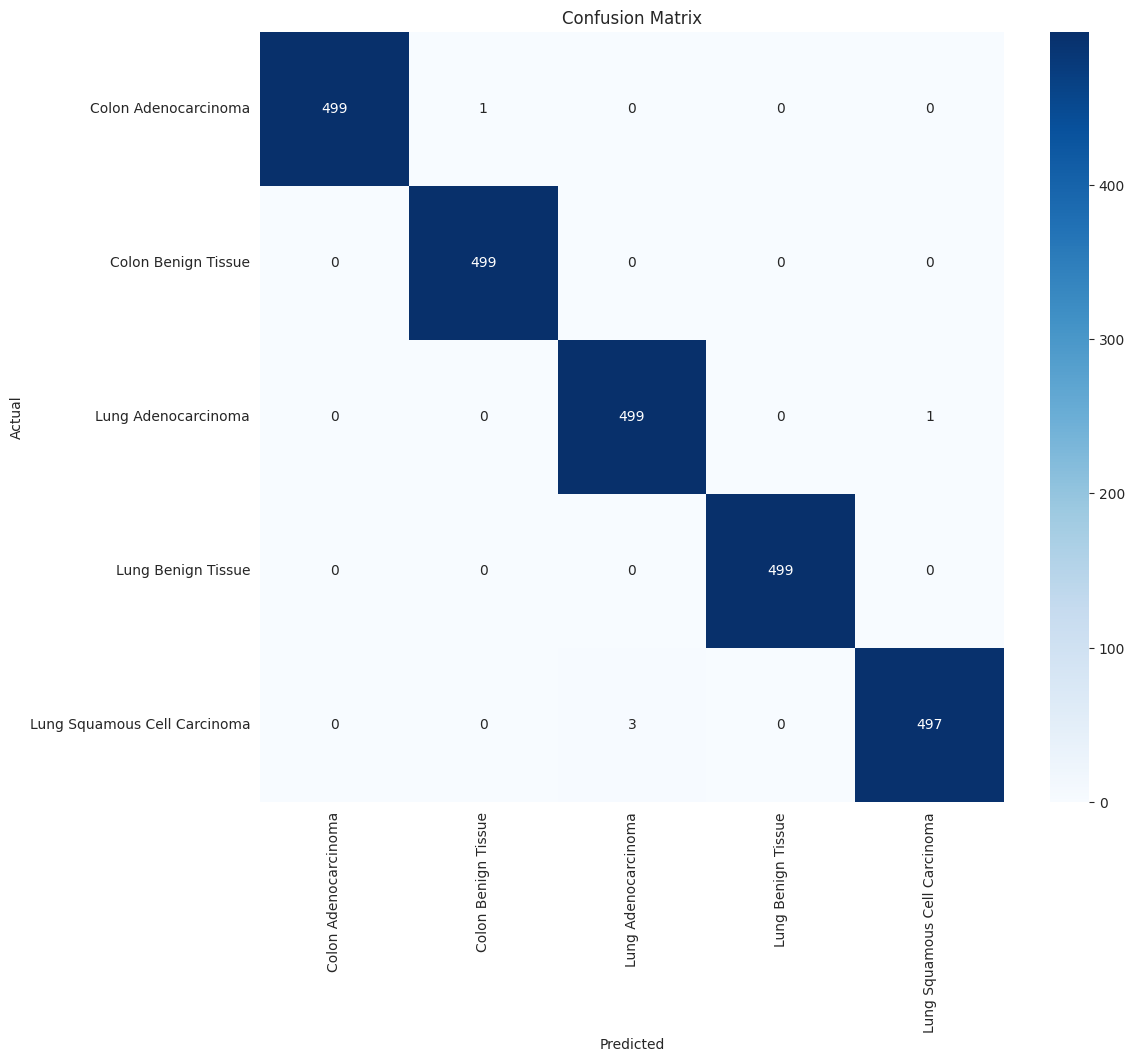

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_images, test_labels = next(test_gen)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_images), axis=1)

plt.figure(figsize=(20, 20))
wrong = np.where(y_true != y_pred)[0]
for i, idx in enumerate(wrong[:16]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[idx])
    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


<Figure size 2000x2000 with 0 Axes>

## Save the trained model

In [ ]:
model.save('lung_colon_cancer_detection_model.h5')

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step


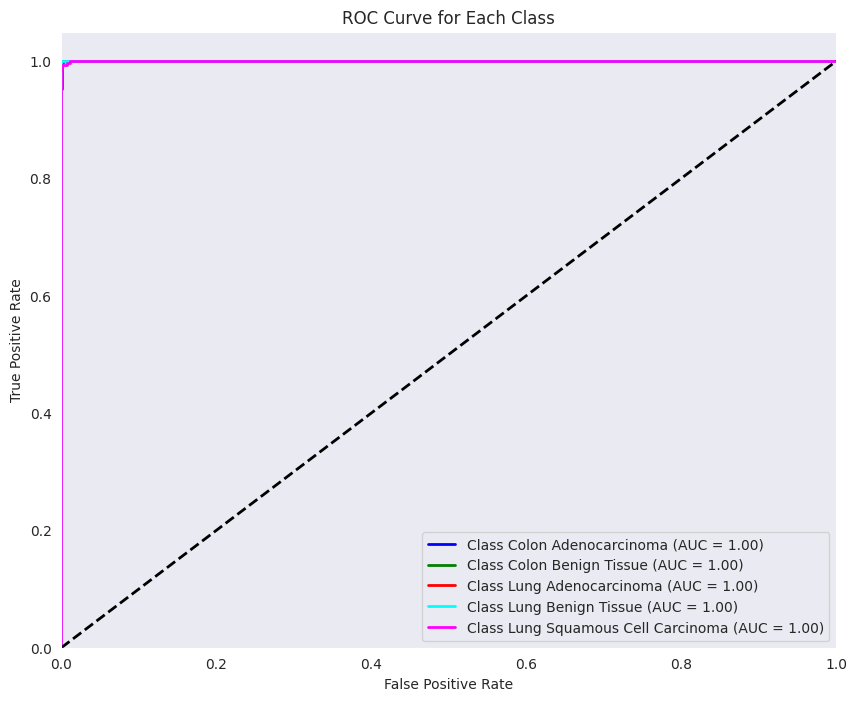

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_true = test_gen.classes
y_prob = model.predict(test_gen)

y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'purple'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Training and Validation Curves

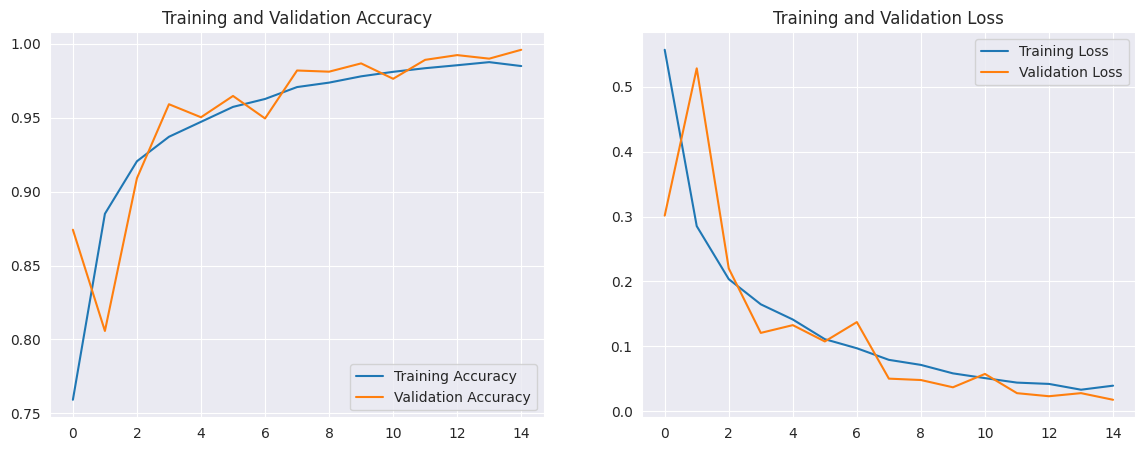

In [ ]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_curves(history)

### Testing on local machine

In [ ]:
class_labels = [
    'Colon Adenocarcinoma',
    'Colon Benign Tissue',
    'Lung Adenocarcinoma',
    'Lung Benign Tissue',
    'Lung Squamous Cell Carcinoma'
]

img = image.load_img(img_path, target_size=(224, 224))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_index = np.argmax(pred)
confidence = np.max(pred)

predicted_class = class_labels[class_index]
print("\nProbabilities per class:")
for i, prob in enumerate(pred):
    print(f"{class_labels[i]:35}: {prob[i]:.4f}")

print("\nFinal Prediction:")
print(f"Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

plt.imshow(img)
plt.title(f'Predicted: {predicted_class}', color='blue')
plt.axis('off')
plt.show()

In [ ]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

In [ ]:
# train the model
epochs = 20   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)